<a href="https://colab.research.google.com/github/yashb98/90Days_Machine_learinng/blob/main/Online%20retail%20Unsupervised(Project%203).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE


In [33]:
# Create output directories
os.makedirs('output_images', exist_ok=True)
os.makedirs('output_data', exist_ok=True)

### Load the Data

In [20]:

file_path = '/content/online_retail_II.csv'
print('Loading:', file_path)
df = pd.read_csv(file_path)
print('Rows,Cols:', df.shape)

Loading: /content/online_retail_II.csv
Rows,Cols: (1067371, 8)


In [22]:
# Quick peek
print(df.columns.tolist())
print(df.head())

['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


### Initial EDA - Overview

In [23]:

print('\n--- Initial overview ---')
print('Missing per column:\n', df.isnull().sum())
print('\nData types:\n', df.dtypes)




--- Initial overview ---
Missing per column:
 Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

Data types:
 Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object


In [24]:
# Basic stats for numeric columns
print('\nNumeric summary:\n', df.describe(include=[np.number]).T)




Numeric summary:
                 count          mean          std      min       25%       50%  \
Quantity     824364.0     12.414574   188.976099 -80995.0      2.00      5.00   
Price        824364.0      3.676800    70.241388      0.0      1.25      1.95   
Customer ID  824364.0  15324.638504  1697.464450  12346.0  13975.00  15255.00   

                  75%      max  
Quantity        12.00  80995.0  
Price            3.75  38970.0  
Customer ID  16797.00  18287.0  


In [25]:
# Unique counts for some identifiers
print('\nUnique Invoices:', df['Invoice'].nunique())
if 'Customer ID' in df.columns:
    print('Unique Customers:', df['Customer ID'].nunique())
print('Unique StockCodes:', df['StockCode'].nunique())


Unique Invoices: 44876
Unique Customers: 5942
Unique StockCodes: 4646


In [26]:
# 3) EDA - Visualizations & insights
# Convert column names to consistent names if necessary
# Many versions use 'Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country'
# Normalize column names
df = df.rename(columns=lambda x: x.strip())
cols = {c: c for c in df.columns}


In [27]:
# Try to map common variants
if 'Invoice' not in df.columns and 'InvoiceNo' in df.columns:
    df.rename(columns={'InvoiceNo': 'Invoice'}, inplace=True)
if 'InvoiceDate' not in df.columns and 'InvoiceDate' in df.columns:
    pass
if 'Price' not in df.columns and 'UnitPrice' in df.columns:
    df.rename(columns={'UnitPrice': 'Price'}, inplace=True)
if 'Customer ID' not in df.columns and 'CustomerID' in df.columns:
    df.rename(columns={'CustomerID': 'Customer ID'}, inplace=True)



In [28]:
# Ensure dates
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])



In [29]:
# Add TotalPrice
if 'TotalPrice' not in df.columns:
    df['TotalPrice'] = df['Quantity'] * df['Price']



/tmp/ipython-input-3910849736.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tx_per_month = df.set_index('InvoiceDate').resample('M')['Invoice'].nunique()


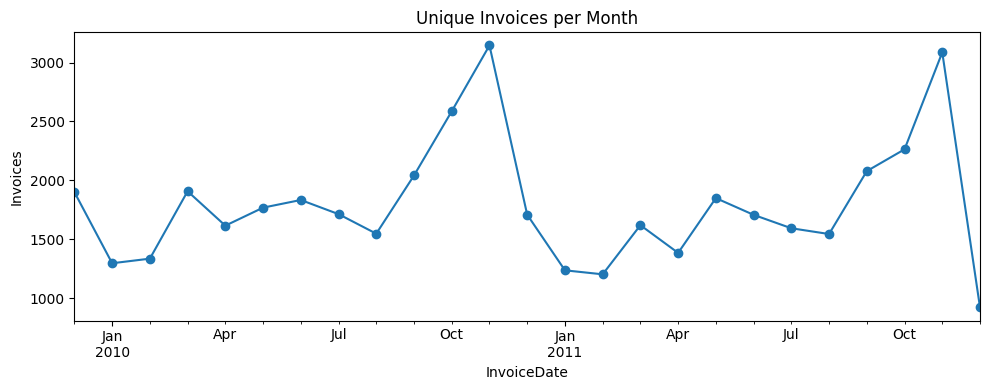

In [39]:
# Time-series: transactions per month
tx_per_month = df.set_index('InvoiceDate').resample('M')['Invoice'].nunique()
plt.figure(figsize=(10,4))
tx_per_month.plot(marker='o')
plt.title('Unique Invoices per Month')
plt.ylabel('Invoices')
plt.tight_layout()
plt.savefig('output_images/invoices_per_month.png')
plt.show()
plt.close()



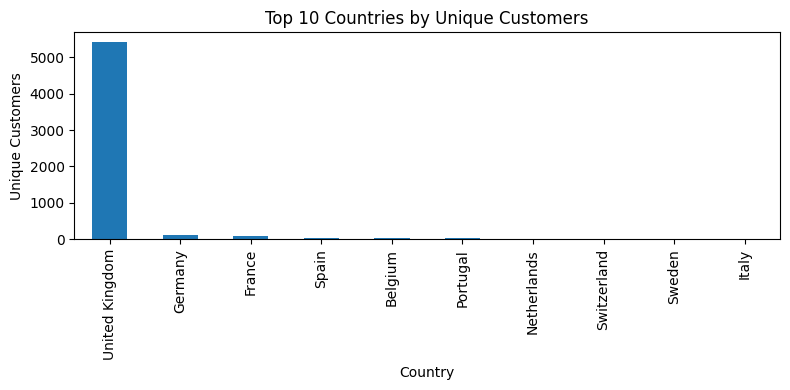

In [40]:
# Top countries by unique customers
country_counts = df[['Country','Customer ID']].drop_duplicates().groupby('Country').size().sort_values(ascending=False)
plt.figure(figsize=(8,4))
country_counts.head(10).plot(kind='bar')
plt.title('Top 10 Countries by Unique Customers')
plt.ylabel('Unique Customers')
plt.tight_layout()
plt.savefig('output_images/top_countries_customers.png')
plt.show()
plt.close()



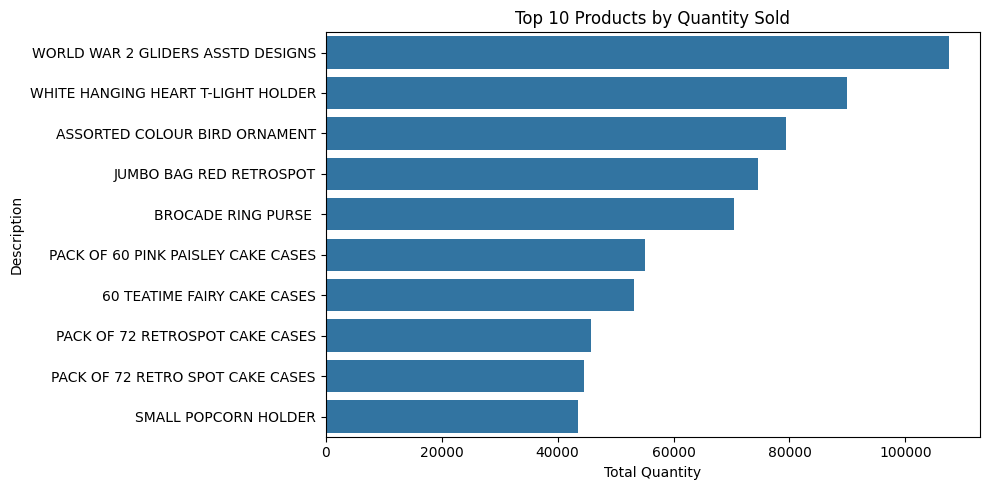

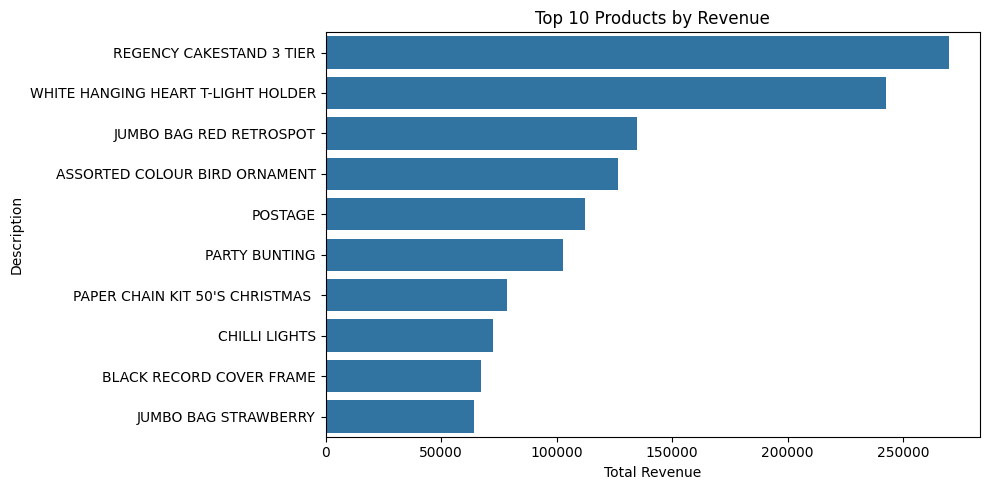

In [41]:
# Top products by quantity and by revenue
top_products_qty = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_products_qty.values, y=top_products_qty.index)
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Total Quantity')
plt.tight_layout()
plt.savefig('output_images/top_products_qty.png')
plt.show()
plt.close()

plt.figure(figsize=(10,5))
sns.barplot(x=top_products_revenue.values, y=top_products_revenue.index)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.tight_layout()
plt.savefig('output_images/top_products_revenue.png')
plt.show()
plt.close()



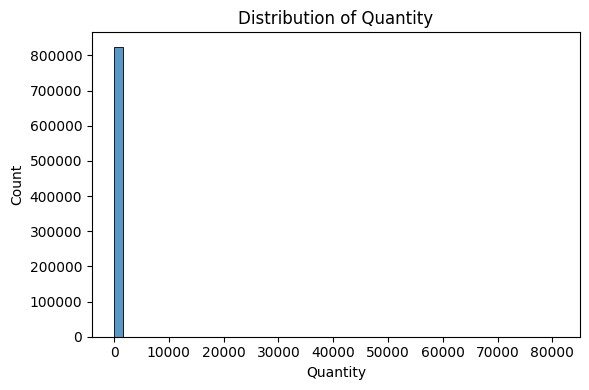

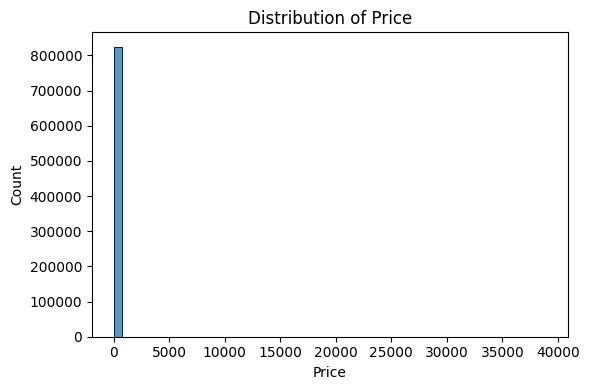

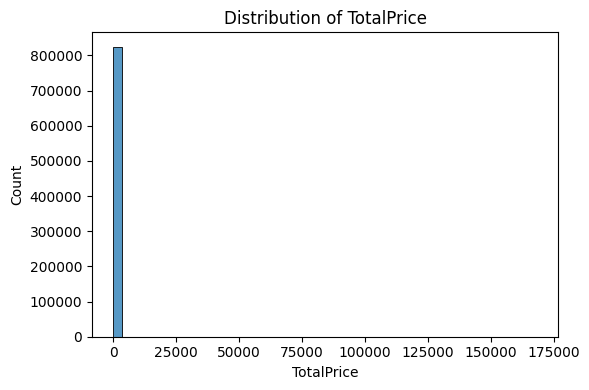

In [42]:
# Distribution plots for key numeric features
num_cols = ['Quantity','Price','TotalPrice']
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].clip(lower=0), bins=50, kde=False)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig(f'output_images/dist_{col}.png')
    plt.show()
    plt.close()



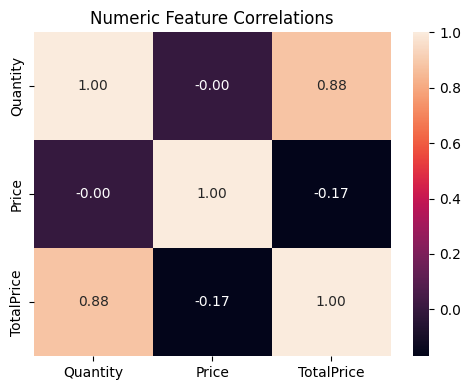

In [43]:
# Correlation heatmap on numeric features (sampled to speed up if huge)
sample = df[['Quantity','Price','TotalPrice']].sample(frac=0.5, random_state=42) if len(df)>200000 else df[['Quantity','Price','TotalPrice']]
plt.figure(figsize=(5,4))
sns.heatmap(sample.corr(), annot=True, fmt='.2f')
plt.title('Numeric Feature Correlations')
plt.tight_layout()
plt.savefig('output_images/corr_heatmap.png')
plt.show()
plt.close()

### Data Cleaning Steps (concrete)

In [44]:

print('\n--- Data cleaning steps ---')
#  Drop rows without Customer ID (we need customer-level features)
before = len(df)
df = df.dropna(subset=['Customer ID'])
print(f'Dropped {before - len(df)} rows without Customer ID')



--- Data cleaning steps ---
Dropped 0 rows without Customer ID


In [45]:

#  Remove cancelled orders - Invoice starting with 'C' (varies by dataset)
before = len(df)
df = df[~df['Invoice'].astype(str).str.startswith('C')]
print(f'Dropped {before - len(df)} cancelled invoice rows')



Dropped 18744 cancelled invoice rows


In [46]:
#  Remove negative or zero Quantity or Price
before = len(df)
df = df[(df['Quantity']>0) & (df['Price']>0)]
print(f'Dropped {before - len(df)} rows with non-positive Quantity/Price')



Dropped 71 rows with non-positive Quantity/Price


In [47]:
#  Strip whitespace in 'Description' and drop duplicates of identical rows if any
if 'Description' in df.columns:
    df['Description'] = df['Description'].astype(str).str.strip()



In [48]:
#  Recompute TotalPrice
df['TotalPrice'] = df['Quantity'] * df['Price']

print('After cleaning, rows:', len(df))



After cleaning, rows: 805549


In [49]:
# Save cleaned sample
df.to_csv('output_data/cleaned_transactions_sample.csv', index=False)


## Detailed EDA after cleaning

In [51]:

# Top customers by revenue and by transactions
cust_revenue = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False)
cust_tx = df.groupby('Customer ID')['Invoice'].nunique().sort_values(ascending=False)

print('\nTop 10 customers by revenue:\n', cust_revenue.head(10))
print('\nTop 10 customers by invoice count:\n', cust_tx.head(10))




Top 10 customers by revenue:
 Customer ID
18102.0    608821.65
14646.0    528602.52
14156.0    313946.37
14911.0    295972.63
17450.0    246973.09
13694.0    196482.81
17511.0    175603.55
16446.0    168472.50
16684.0    147142.77
12415.0    144458.37
Name: TotalPrice, dtype: float64

Top 10 customers by invoice count:
 Customer ID
14911.0    398
12748.0    336
17841.0    211
15311.0    208
13089.0    203
14606.0    192
14156.0    156
17850.0    155
14646.0    151
18102.0    145
Name: Invoice, dtype: int64


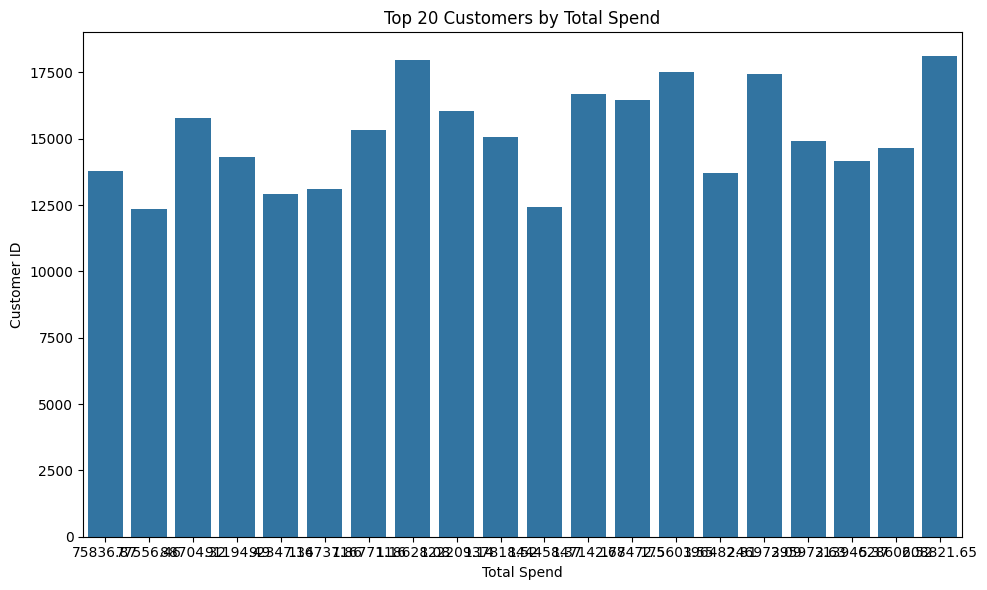

In [52]:
# Plot top 20 customers by revenue
plt.figure(figsize=(10,6))
sns.barplot(x=cust_revenue.head(20).values, y=cust_revenue.head(20).index)
plt.title('Top 20 Customers by Total Spend')
plt.xlabel('Total Spend')
plt.tight_layout()
plt.savefig('output_images/top_customers_revenue.png')
plt.show()
plt.close()



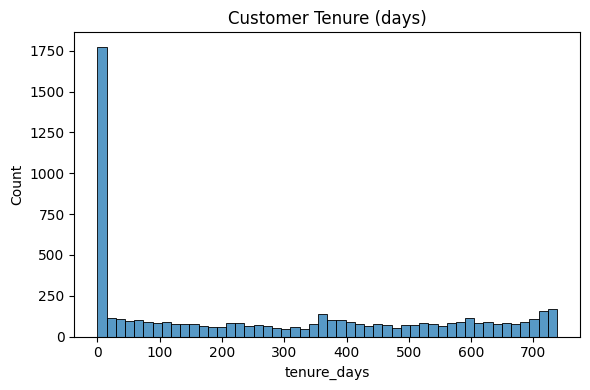

In [53]:
# Time between first and last purchase per customer (tenure)
cust_dates = df.groupby('Customer ID')['InvoiceDate'].agg(['min','max'])
cust_dates['tenure_days'] = (cust_dates['max'] - cust_dates['min']).dt.days
plt.figure(figsize=(6,4))
sns.histplot(cust_dates['tenure_days'].clip(lower=0), bins=50)
plt.title('Customer Tenure (days)')
plt.tight_layout()
plt.savefig('output_images/tenure_days.png')
plt.show()
plt.close()



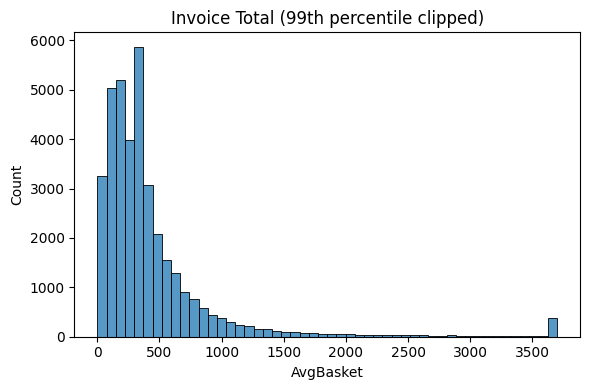

In [54]:
# Average basket value per invoice
invoice_agg = df.groupby('Invoice').agg({'TotalPrice':'sum','Customer ID':'first'})
invoice_agg['AvgBasket'] = invoice_agg['TotalPrice']
plt.figure(figsize=(6,4))
sns.histplot(invoice_agg['AvgBasket'].clip(upper=invoice_agg['AvgBasket'].quantile(0.99)), bins=50)
plt.title('Invoice Total (99th percentile clipped)')
plt.tight_layout()
plt.savefig('output_images/invoice_total_dist.png')
plt.show()
plt.close()

## Feature Engineering - Customer-level aggregation (RFM + extras)

In [55]:

# Reference date for recency = max date in dataset + 1 day to avoid zero recency
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

customer_df = df.groupby('Customer ID').agg(
    NumInvoices = ('Invoice','nunique'),
    NumTransactions = ('Invoice','count'),
    TotalQuantity = ('Quantity','sum'),
    TotalSpend = ('TotalPrice','sum'),
    AvgPrice = ('Price','mean'),
    FirstPurchase = ('InvoiceDate','min'),
    LastPurchase = ('InvoiceDate','max')
).reset_index()

# Recency
customer_df['RecencyDays'] = (reference_date - customer_df['LastPurchase']).dt.days
# Frequency: use NumInvoices
# Monetary: TotalSpend
# Tenure
customer_df['TenureDays'] = (customer_df['LastPurchase'] - customer_df['FirstPurchase']).dt.days
# Average spend per invoice
customer_df['AvgSpendPerInvoice'] = customer_df['TotalSpend'] / customer_df['NumInvoices']
# Average quantity per invoice
customer_df['AvgQtyPerInvoice'] = customer_df['TotalQuantity'] / customer_df['NumInvoices']

# Replace infinities / NaNs
customer_df.replace([np.inf, -np.inf], np.nan, inplace=True)
customer_df.fillna(0, inplace=True)

print('\nCustomer-level feature sample:')
print(customer_df.head())

# Save customer-level data
customer_df.to_csv('output_data/customer_features_raw.csv', index=False)



Customer-level feature sample:
   Customer ID  NumInvoices  NumTransactions  TotalQuantity  TotalSpend  \
0      12346.0           12               34          74285    77556.46   
1      12347.0            8              253           3286     5633.32   
2      12348.0            5               51           2714     2019.40   
3      12349.0            4              175           1624     4428.69   
4      12350.0            1               17            197      334.40   

   AvgPrice       FirstPurchase        LastPurchase  RecencyDays  TenureDays  \
0  6.100000 2009-12-14 08:34:00 2011-01-18 10:01:00          326         400   
1  2.546087 2010-10-31 14:20:00 2011-12-07 15:52:00            2         402   
2  3.786275 2010-09-27 14:59:00 2011-09-25 13:13:00           75         362   
3  8.459657 2010-04-29 13:20:00 2011-11-21 09:51:00           19         570   
4  3.841176 2011-02-02 16:01:00 2011-02-02 16:01:00          310           0   

   AvgSpendPerInvoice  AvgQtyPerInvo

## Prepare features for clustering

In [56]:

features = ['RecencyDays','NumInvoices','NumTransactions','TotalQuantity','TotalSpend',
            'AvgPrice','TenureDays','AvgSpendPerInvoice','AvgQtyPerInvoice']

X = customer_df[features].copy()

# Option: apply log-transform to heavily skewed features (TotalSpend, TotalQuantity, NumTransactions)
skewed = ['TotalSpend','TotalQuantity','NumTransactions','AvgSpendPerInvoice']
for col in skewed:
    X[col+'_log'] = np.log1p(X[col])

# Choose final features (mix of original and log-transformed to reduce skew)
final_features = ['RecencyDays','NumInvoices','TenureDays','AvgPrice','AvgQtyPerInvoice',
                  'TotalSpend_log','TotalQuantity_log','NumTransactions_log','AvgSpendPerInvoice_log']

X_final = X[final_features].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Save scaler and scaled features
pd.DataFrame(X_scaled, columns=final_features).to_csv('output_data/customer_features_scaled.csv', index=False)


## Determine optimal K: Elbow + Silhouette

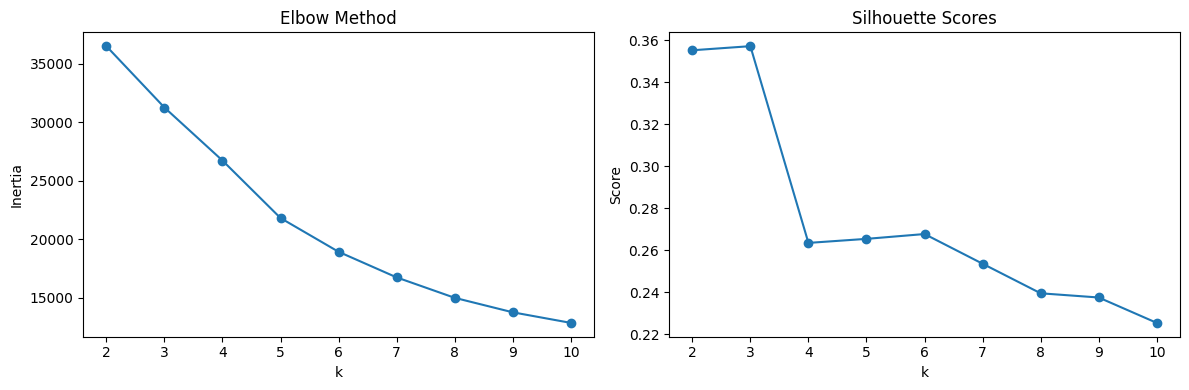

In [58]:


inertia = []
silhouette = []
K_range = range(2,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('k')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('output_images/elbow_silhouette.png')
plt.show()
plt.close()

# Choose k (you can change based on plot). We'll pick k=5 as a strong starting point
k_opt = 5


## Fit final K-Means and attach clusters

In [61]:

kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init=20)
customer_df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Save cluster centers (in scaled space) and inverse-transform to interpret
centers_scaled = kmeans_final.cluster_centers_
centers_df = pd.DataFrame(scaler.inverse_transform(centers_scaled), columns=final_features)
centers_df.to_csv('output_data/cluster_centers_interpretable.csv', index=False)

# Save customer assignments
customer_df.to_csv('output_data/customer_features_with_clusters.csv', index=False)


##  PCA for 2D visualization

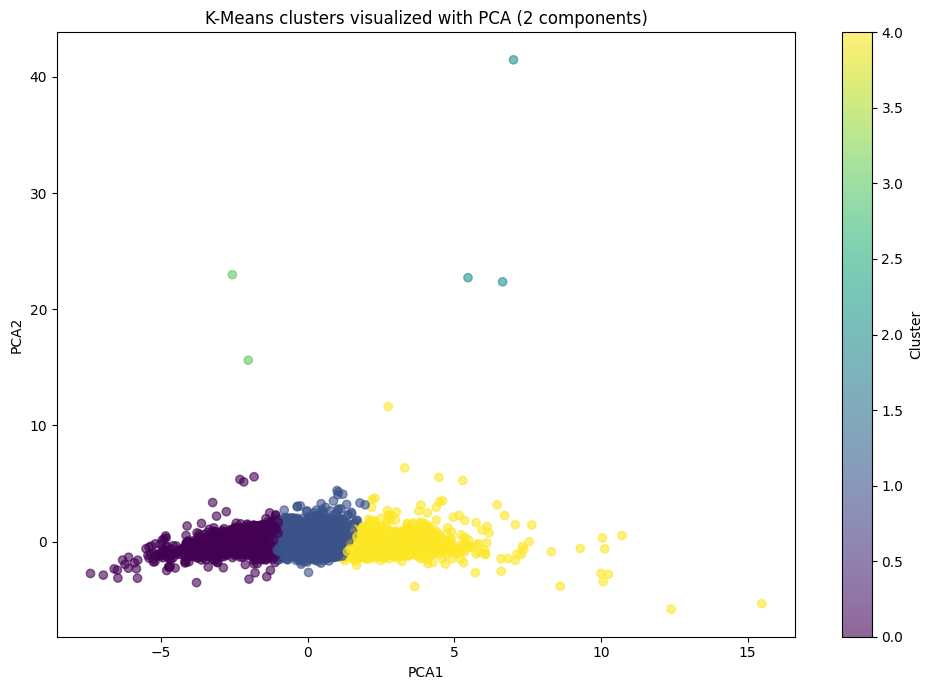


PCA explained variance ratios: [0.482608  0.1394121]


In [63]:

pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)
customer_df['PCA1'] = pc[:,0]
customer_df['PCA2'] = pc[:,1]

plt.figure(figsize=(10,7))
plt.scatter(customer_df['PCA1'], customer_df['PCA2'], c=customer_df['Cluster'], alpha=0.6)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('K-Means clusters visualized with PCA (2 components)')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig('output_images/pca_clusters.png')
plt.show()
plt.close()

# Explained variance
explained = pca.explained_variance_ratio_
print('\nPCA explained variance ratios:', explained)


## t-SNE (optional) — can reveal non-linear structure

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


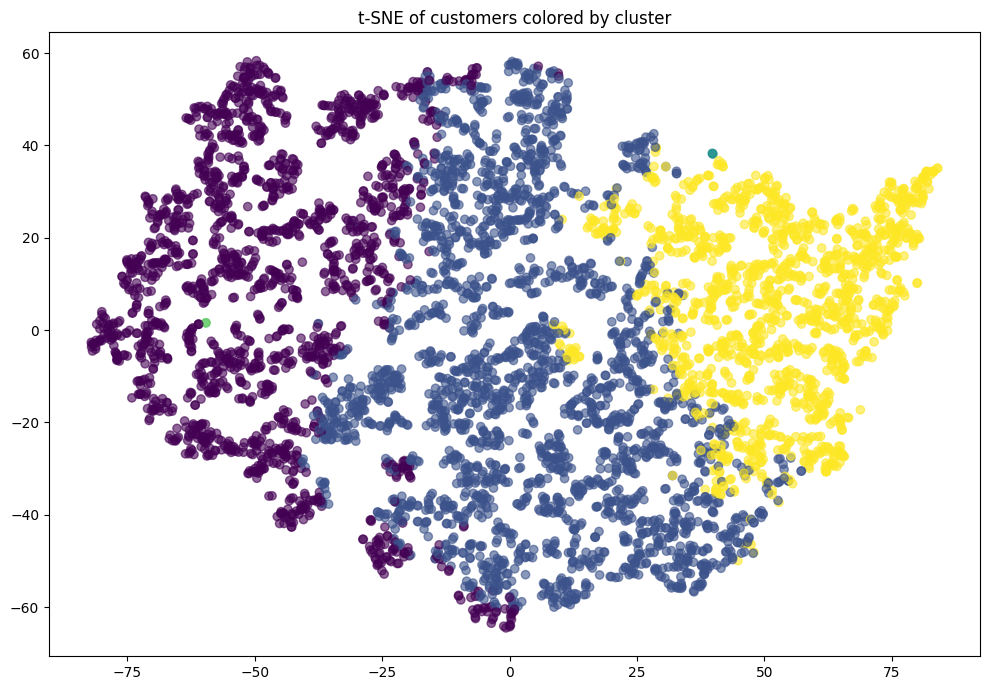

In [64]:

try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_res = tsne.fit_transform(X_scaled)
    customer_df['TSNE1'] = tsne_res[:,0]
    customer_df['TSNE2'] = tsne_res[:,1]
    plt.figure(figsize=(10,7))
    plt.scatter(customer_df['TSNE1'], customer_df['TSNE2'], c=customer_df['Cluster'], alpha=0.6)
    plt.title('t-SNE of customers colored by cluster')
    plt.tight_layout()
    plt.savefig('output_images/tsne_clusters.png')
    plt.show()
    plt.close()
except Exception as e:
    print('t-SNE failed or skipped:', e)


## Cluster profiling - detailed


--- Cluster 0 ---
Customers: 1853
Mean TotalSpend: 275.36
Median RecencyDays: 406.0
Mean NumInvoices: 1.47
Mean AvgSpendPerInvoice: 203.96

--- Cluster 1 ---
Customers: 2598
Mean TotalSpend: 1208.85
Median RecencyDays: 79.0
Mean NumInvoices: 3.75
Mean AvgSpendPerInvoice: 393.72

--- Cluster 2 ---
Customers: 3
Mean TotalSpend: 71482.87
Median RecencyDays: 438.0
Mean NumInvoices: 2.67
Mean AvgSpendPerInvoice: 34312.05

--- Cluster 3 ---
Customers: 2
Mean TotalSpend: 12434.92
Median RecencyDays: 628.5
Mean NumInvoices: 1.5
Mean AvgSpendPerInvoice: 8955.83

--- Cluster 4 ---
Customers: 1422
Mean TotalSpend: 9742.11
Median RecencyDays: 24.0
Mean NumInvoices: 17.22
Mean AvgSpendPerInvoice: 549.15


<Figure size 1000x600 with 0 Axes>

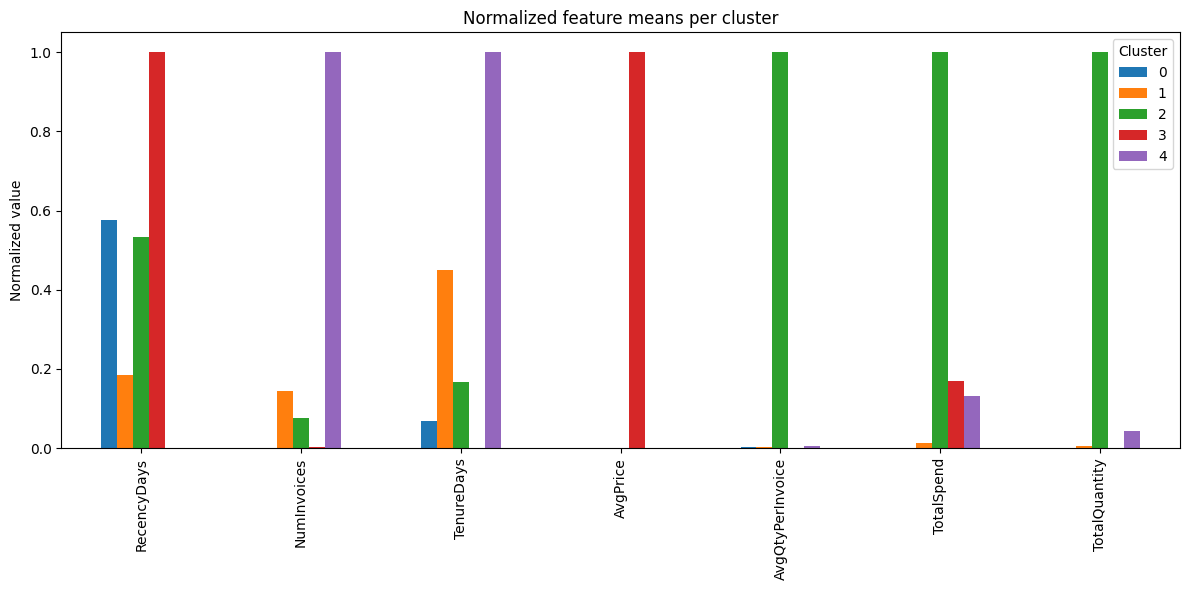

In [65]:

cluster_profile = customer_df.groupby('Cluster')[['NumInvoices','NumTransactions','TotalQuantity','TotalSpend',
                                                   'AvgPrice','RecencyDays','TenureDays','AvgSpendPerInvoice','AvgQtyPerInvoice']].agg(['count','mean','median','std']).round(2)
cluster_profile.to_csv('output_data/cluster_profile_stats.csv')

# Print summary to console
for c in sorted(customer_df['Cluster'].unique()):
    print('\n--- Cluster', c, '---')
    sub = customer_df[customer_df['Cluster']==c]
    print('Customers:', len(sub))
    print('Mean TotalSpend:', sub['TotalSpend'].mean().round(2))
    print('Median RecencyDays:', sub['RecencyDays'].median())
    print('Mean NumInvoices:', sub['NumInvoices'].mean().round(2))
    print('Mean AvgSpendPerInvoice:', sub['AvgSpendPerInvoice'].mean().round(2))

# Radar chart or bar plots per cluster (mean of standardized features)
cluster_means = customer_df.groupby('Cluster')[['RecencyDays','NumInvoices','TenureDays','AvgPrice','AvgQtyPerInvoice','TotalSpend','TotalQuantity']].mean()
cluster_means.to_csv('output_data/cluster_means.csv')

plt.figure(figsize=(10,6))
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
cluster_means_norm.T.plot(kind='bar', figsize=(12,6))
plt.title('Normalized feature means per cluster')
plt.ylabel('Normalized value')
plt.tight_layout()
plt.savefig('output_images/cluster_feature_means.png')
plt.show()
plt.close()




##  Country distribution per cluster (if Country info available)

In [66]:

if 'Country' in df.columns:
    cust_country = df[['Customer ID','Country']].drop_duplicates()
    ccl = pd.merge(customer_df[['Customer ID','Cluster']], cust_country, left_on='Customer ID', right_on='Customer ID', how='left')
    country_cluster = ccl.groupby(['Country','Cluster']).size().unstack(fill_value=0)
    country_cluster.to_csv('output_data/country_cluster_counts.csv')
    # Save top countries per cluster
    top_countries = {}
    for c in sorted(customer_df['Cluster'].unique()):
        s = country_cluster[c].sort_values(ascending=False).head(5)
        top_countries[c] = s.index.tolist()
    print('\nTop countries per cluster (top 5):', top_countries)




Top countries per cluster (top 5): {np.int32(0): ['United Kingdom', 'France', 'Germany', 'Spain', 'Netherlands'], np.int32(1): ['United Kingdom', 'Germany', 'France', 'Spain', 'Belgium'], np.int32(2): ['United Kingdom', 'Denmark', 'Bahrain', 'Austria', 'Brazil'], np.int32(3): ['United Kingdom', 'Norway', 'Bahrain', 'Austria', 'Brazil'], np.int32(4): ['United Kingdom', 'Germany', 'France', 'Belgium', 'Spain']}


## Actions & Recommendations (to include in your report)

In [67]:


recommendations = {
    'High-Value-Loyal': 'Offer VIP loyalty programs, early access to new products, exclusive discounts.',
    'Recent-High-Spenders': 'Upsell complementary products and ask for referrals.',
    'At-Risk-Dormant': 'Run re-engagement campaigns with discounts and personalized emails.',
    'Occasional-Big-Spenders': 'Cross-sell and targeted ad campaigns during peak seasons.',
    'Low-Value-Frequent': 'Bundle products to increase average order value and encourage upsells.'
}

with open('output_data/recommendations.txt','w') as f:
    f.write('Suggested marketing actions based on cluster profiling:\n')
    for k,v in recommendations.items():
        f.write(f'{k}: {v}\n')

print('\nAll artifacts saved under output_images/ and output_data/.')
print('Open output_data/customer_features_with_clusters.csv for cluster assignments.')



All artifacts saved under output_images/ and output_data/.
Open output_data/customer_features_with_clusters.csv for cluster assignments.
